In [37]:
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
import numpy as np

class MDP:
    '''A simple MDP class.  It includes the following members'''

    def __init__(self,T,R,discount):
        '''Constructor for the MDP class

        Inputs:
        T -- Transition function: |A| x |S| x |S'| array
        R -- Reward function: |A| x |S| array
        discount -- discount factor: scalar in [0,1)

        The constructor verifies that the inputs are valid and sets
        corresponding variables in a MDP object'''

        assert T.ndim == 3, "Invalid transition function: it should have 3 dimensions"
        self.nActions = T.shape[0]
        self.nStates = T.shape[1]
        assert T.shape == (self.nActions,self.nStates,self.nStates), "Invalid transition function: it has dimensionality " + repr(T.shape) + ", but it should be (nActions,nStates,nStates)"
        assert (abs(T.sum(2)-1) < 1e-5).all(), "Invalid transition function: some transition probability does not equal 1"
        self.T = T
        assert R.ndim == 2, "Invalid reward function: it should have 2 dimensions" 
        assert R.shape == (self.nActions,self.nStates), "Invalid reward function: it has dimensionality " + repr(R.shape) + ", but it should be (nActions,nStates)"
        self.R = R
        assert 0 <= discount < 1, "Invalid discount factor: it should be in [0,1)"
        self.discount = discount
        
    def valueIteration(self,initialV,nIterations=np.inf,tolerance=0.01):
        '''Value iteration procedure
        V <-- max_a R^a + gamma T^a V

        Inputs:
        initialV -- Initial value function: array of |S| entries
        nIterations -- limit on the # of iterations: scalar (default: infinity)
        tolerance -- threshold on ||V^n-V^n+1||_inf: scalar (default: 0.01)

        Outputs: 
        V -- Value function: array of |S| entries
        iterId -- # of iterations performed: scalar
        epsilon -- ||V^n-V^n+1||_inf: scalar'''
        
        # temporary values to ensure that the code compiles until this
        # function is coded
        V = initialV
        iterId = 0
        epsilon = np.inf
        
        while (iterId < nIterations and epsilon > tolerance):
          iterId += 1
          V_matrix = []
          for i in range(self.nActions):
            V_matrix.append(self.R[i]+self.discount*self.T[i] @ V)
          V_next = np.amax(np.array(V_matrix), 0)
          epsilon = np.max(np.abs(V_next - V))
          V = V_next
          
        return [V,iterId,epsilon]
          

    def extractPolicy(self,V):
        '''Procedure to extract a policy from a value function
        pi <-- argmax_a R^a + gamma T^a V

        Inputs:
        V -- Value function: array of |S| entries

        Output:
        policy -- Policy: array of |S| entries'''

        # temporary values to ensure that the code compiles until this
        # function is coded
        policy = np.zeros(self.nStates)
        
        V_matrix = []
        for i in range(self.nActions):
          V_matrix.append(self.R[i]+self.discount*self.T[i] @ V)
        policy = np.array(V_matrix).argmax(0)

        return policy 

    def evaluatePolicy(self,policy):
        '''Evaluate a policy by solving a system of linear equations
        V^pi = R^pi + gamma T^pi V^pi

        Input:
        policy -- Policy: array of |S| entries

        Ouput:
        V -- Value function: array of |S| entries'''

        # temporary values to ensure that the code compiles until this
        # function is coded
        V = np.zeros(self.nStates)
        
        R_pi = np.zeros(self.nStates)
        for i in range(self.nStates):
          R_pi[i] = self.R[policy[i]][i]
        
        T_pi = np.zeros([self.nStates,self.nStates])
        for i in range(self.nStates):
          T_pi[i] = self.T[policy[i]][i]
        
        V = np.linalg.pinv(np.identity(self.nStates) - self.discount*T_pi) @ R_pi

        return V
        
    def policyIteration(self,initialPolicy,nIterations=np.inf):
        '''Policy iteration procedure: alternate between policy
        evaluation (solve V^pi = R^pi + gamma T^pi V^pi) and policy
        improvement (pi <-- argmax_a R^a + gamma T^a V^pi).

        Inputs:
        initialPolicy -- Initial policy: array of |S| entries
        nIterations -- limit on # of iterations: scalar (default: inf)

        Outputs: 
        policy -- Policy: array of |S| entries
        V -- Value function: array of |S| entries
        iterId -- # of iterations peformed by modified policy iteration: scalar
        epsilon -- ||V^n-V^n+1||_inf: scalar'''

        # temporary values to ensure that the code compiles until this
        # function is coded
        policy = initialPolicy
        V = np.zeros(self.nStates)
        iterId = 0
        
        while(iterId < nIterations):
          iterId += 1
          V = self.evaluatePolicy(policy)
          policy_next = self.extractPolicy(V)
          if np.array_equal(policy, policy_next):
            return [policy,V,iterId]
          policy = policy_next
          
        return [policy, V, iterId]
          
    def evaluatePolicyPartially(self,policy,initialV,nIterations=np.inf,tolerance=0.01):
        '''Partial policy evaluation:
        Repeat V^pi <-- R^pi + gamma T^pi V^pi

        Inputs:
        policy -- Policy: array of |S| entries
        initialV -- Initial value function: array of |S| entries
        nIterations -- limit on the # of iterations: scalar (default: infinity)
        tolerance -- threshold on ||V^n-V^n+1||_inf: scalar (default: 0.01)

        Outputs: 
        V -- Value function: array of |S| entries
        iterId -- # of iterations performed: scalar
        epsilon -- ||V^n-V^n+1||_inf: scalar'''

        # temporary values to ensure that the code compiles until this
        # function is coded
        V = initialV
        iterId = 0
        epsilon = np.inf
        
        R_pi = np.zeros(self.nStates)
        for i in range(self.nStates):
          R_pi[i] = self.R[policy[i]][i]
        
        T_pi = np.zeros([self.nStates,self.nStates])
        for i in range(self.nStates):
          T_pi[i] = self.T[policy[i]][i]
          
        while(iterId < nIterations and epsilon > tolerance):
          iterId += 1
          V_next = R_pi + self.discount*T_pi @ V
          epsilon = np.max(np.abs(V_next - V))
          V = V_next

        return [V,iterId,epsilon]

    def modifiedPolicyIteration(self,initialPolicy,initialV,nEvalIterations=5,nIterations=np.inf,tolerance=0.01):
        '''Modified policy iteration procedure: alternate between
        partial policy evaluation (repeat a few times V^pi <-- R^pi + gamma T^pi V^pi)
        and policy improvement (pi <-- argmax_a R^a + gamma T^a V^pi)

        Inputs:
        initialPolicy -- Initial policy: array of |S| entries
        initialV -- Initial value function: array of |S| entries
        nEvalIterations -- limit on # of iterations to be performed in each partial policy evaluation: scalar (default: 5)
        nIterations -- limit on # of iterations to be performed in modified policy iteration: scalar (default: inf)
        tolerance -- threshold on ||V^n-V^n+1||_inf: scalar (default: 0.01)

        Outputs: 
        policy -- Policy: array of |S| entries
        V -- Value function: array of |S| entries
        iterId -- # of iterations peformed by modified policy iteration: scalar
        epsilon -- ||V^n-V^n+1||_inf: scalar'''

        # temporary values to ensure that the code compiles until this
        # function is coded
        policy = initialPolicy
        V = initialV
        iterId = 0
        epsilon = np.inf
        
        while(iterId < nIterations and epsilon > tolerance):
          iterId += 1
          [V, _, _] = self.evaluatePolicyPartially(policy,V,nEvalIterations,tolerance=0.01)
          policy = self.extractPolicy(V)
          [V_next, _, _] = self.valueIteration(V,1)
          epsilon = np.max(np.abs(V_next - V))
          

        return [policy,V,iterId,epsilon]

In [39]:
import numpy as np

class RL2:
    def __init__(self,mdp,sampleReward):
        '''Constructor for the RL class

        Inputs:
        mdp -- Markov decision process (T, R, discount)
        sampleReward -- Function to sample rewards (e.g., bernoulli, Gaussian).
        This function takes one argument: the mean of the distributon and 
        returns a sample from the distribution.
        '''

        self.mdp = mdp
        self.sampleReward = sampleReward

    def sampleRewardAndNextState(self,state,action):
        '''Procedure to sample a reward and the next state
        reward ~ Pr(r)
        nextState ~ Pr(s'|s,a)

        Inputs:
        state -- current state
        action -- action to be executed

        Outputs: 
        reward -- sampled reward
        nextState -- sampled next state
        '''

        reward = self.sampleReward(self.mdp.R[action,state])
        cumProb = np.cumsum(self.mdp.T[action,state,:])
        nextState = np.where(cumProb >= np.random.rand(1))[0][0]
        return [reward,nextState]

    def sampleAction(self,q):
        a = q - np.max(q)
        a = np.exp(a) / np.sum(np.exp(a))
        return np.where(np.cumsum(a) >= np.random.rand(1))[0][0]

    def sampleSoftmaxPolicy(self,policyParams,state):
        '''Procedure to sample an action from stochastic policy
        pi(a|s) = exp(policyParams(a,s))/[sum_a' exp(policyParams(a',s))])
        This function should be called by reinforce() to selection actions

        Inputs:
        policyParams -- parameters of a softmax policy (|A|x|S| array)
        state -- current state

        Outputs: 
        action -- sampled action
        '''

        # temporary value to ensure that the code compiles until this
        # function is coded
        pi = policyParams[:,state]
        pi = pi - np.max(pi)
        pi = np.exp(pi) / np.sum(np.exp(pi))
        action = np.where(np.cumsum(pi) >= np.random.rand(1))[0][0]
                          
        return action

    def modelBasedRL(self,s0,defaultT,initialR,nEpisodes,nSteps,epsilon=0):
        '''Model-based Reinforcement Learning with epsilon greedy 
        exploration.  This function should use value iteration,
        policy iteration or modified policy iteration to update the policy at each step

        Inputs:
        s0 -- initial state
        defaultT -- default transition function when a state-action pair has not been vsited
        initialR -- initial estimate of the reward function
        nEpisodes -- # of episodes (one episode consists of a trajectory of nSteps that starts in s0
        nSteps -- # of steps per episode
        epsilon -- probability with which an action is chosen at random

        Outputs: 
        V -- final value function
        policy -- final policy
        '''

        # temporary values to ensure that the code compiles until this
        # function is coded
        count_triple = np.ones([self.mdp.nActions, self.mdp.nStates, self.mdp.nStates])
        cumu_reward_lst = np.zeros(nEpisodes)
        V = np.zeros(self.mdp.nStates)
        policy = np.zeros(self.mdp.nStates,int)
        mdp_tmp = MDP(defaultT, initialR, self.mdp.discount)
        
        for iterEp in range(nEpisodes):
            state = s0
            for iterSt in range(nSteps):
                action = 0
                if np.random.rand(1) < epsilon:
                    action = np.random.randint(self.mdp.nActions)
                else:
                    action = policy[state]
                [reward, nextState] = self.sampleRewardAndNextState(state,action)
                cumu_reward_lst[iterEp] += self.mdp.discount**iterSt * reward
                count_triple[action,state,nextState] += 1
                count_double = np.sum(count_triple[action,state,:])
                mdp_tmp.T[action,state,:] = count_triple[action,state,:] /  count_double
                mdp_tmp.R[action, state] = (reward + (count_double-1) * mdp_tmp.R[action,state]) / count_double
                [policy, V, iterId] = mdp_tmp.policyIteration(policy)
                state = nextState
        return [V,policy,cumu_reward_lst]
    
    def BayesQIteration(self,
                        sim_initialQ,
                        beliefT,beliefR,beliefRC,
                        sampleSize,
                        sim_nEpisodes,
                        sim_nSteps,
                        sim_s0,
                        Sigma,
                        temp=0):
        def DirichletSample(params):
            sample = np.vectorize(np.random.gamma)(params)
            return sample / np.sum(sample)
        simQ_lst=[]
        sim_reward_history=[]
        for iterSam in range(sampleSize):
            simQ=sim_initialQ.copy()
            sim_n_table=np.zeros(simQ.shape,dtype=int)
            sim_learning_rate=1
            sim_episodeId=0
            sim_reward_episodes=[] # list of rewards of each episodes
            # Sample the transition dynamics
            sampleT = np.apply_along_axis(DirichletSample,2,beliefT)
            sampleR = np.vectorize(np.random.normal)(beliefR,1.0/(1+beliefRC))
            while(sim_episodeId < sim_nEpisodes):
                sim_episodeId+=1
                sim_s=sim_s0
                sim_reward_cumu=0
                sim_stepId=0
                sim_discount_factor=1
                while(sim_stepId < sim_nSteps):
                    sim_stepId+=1
                    sim_action=0
                    if(temp != 0):
                        boltz_state = np.exp(simQ[:,s].ravel() / temp)
                        boltz_state = boltz_state / boltz_state.sum()
                        boltz_state = np.cumsum(boltz_state)
                        sim_action = np.where(boltz_state >= np.random.rand(1))[0][0]
                    else:
                        sim_action = simQ[:,sim_s].argmax()
                    sim_reward=sampleR[sim_action][sim_s]
                    sim_s_next=self.sampleAction(sampleT[sim_action][sim_s])
                    sim_reward_cumu+=sim_discount_factor*sim_reward
                    sim_n_table[sim_action,sim_s]+=1
                    sim_learning_rate=1./sim_n_table[sim_action,sim_s]
                    simQ[sim_action,sim_s]+=sim_learning_rate*(sim_reward+self.mdp.discount*np.max(simQ[:,sim_s_next].ravel())-simQ[sim_action,sim_s])
                    sim_discount_factor*=self.mdp.discount
                    sim_s=sim_s_next
                sim_reward_episodes.append(sim_reward_cumu)
            simQ_lst.append(simQ)
            sim_reward_history.append(sim_reward_episodes)
        return [np.array(simQ_lst).mean(0),sim_reward_history]
    
    def BayesModelBasedRL(self,s0,initialQ,nEpisodes,nSteps,sim_nEpisodes,sim_nSteps,
                          Sigma=1):
        '''
        Inputs:
        initialQ is Quality function of size |A| x |S|
        beliefT is a |A| x |S| x |S'| array which is the Bayesian belief of the transition
        dynamics in a family of Dirichlet distribution
        beliefR is a |A| x |S| array which is the Bayesian belief of the mean of rewards
        
        '''
        beliefT=np.ones([self.mdp.nActions, self.mdp.nStates, self.mdp.nStates]) # intial Dirichlet ditribution parameters
        beliefR=np.zeros([self.mdp.nActions, self.mdp.nStates]) # initial weight given to action-state pairs
        beliefRC=np.full([self.mdp.nActions, self.mdp.nStates],0) # count of the time the action-state pair is visited

        episodeId=0
        reward_episodes=[]
        Q=initialQ
        while(episodeId < nEpisodes):
            episodeId+=1
            print("-",end='')
            s=s0       
            stepId=0
            reward_cumu=0
            discount_factor=1
            while(stepId < nSteps):
                stepId+=1
                action=0
                [Q,simH] = self.BayesQIteration(Q,beliefT,beliefR,beliefRC,
                                                sampleSize=10,
                                                sim_nEpisodes=sim_nEpisodes,
                                                sim_nSteps=sim_nSteps,
                                                sim_s0=s0,
                                                Sigma=Sigma,
                                                temp=0)
                
                action = self.sampleAction(Q[:,s].ravel())
                
                [reward,s_next] = self.sampleRewardAndNextState(s,action)
                beliefT[action,s,s_next]+=1
                if(beliefRC[action,s] == 0):
                    beliefR[action,s]=reward
                else:
                    beliefR[action,s]=(beliefRC[action,s]*beliefR[action,s]+reward)/(beliefRC[action,s]+1)
                beliefRC[action,s]+=1
                s=s_next
                reward_cumu+=discount_factor*reward
                discount_factor*=self.mdp.discount
            reward_episodes.append(reward_cumu)
        print()
        policy = Q.argmax(0)
        return [Q,policy,reward_episodes]

    def qLearning(self,s0,initialQ,nEpisodes,nSteps,epsilon=0,temperature=1):
        '''qLearning algorithm.  Epsilon exploration and Boltzmann exploration
        are combined in one procedure by sampling a random action with 
        probabilty epsilon and performing Boltzmann exploration otherwise.  
        When epsilon and temperature are set to 0, there is no exploration.

        Inputs:
        s0 -- initial state
        initialQ -- initial Q function (|A|x|S| array)
        nEpisodes -- # of episodes (one episode consists of a trajectory of nSteps that starts in s0
        nSteps -- # of steps per episode
        epsilon -- probability with which an action is chosen at random
        temperature -- parameter that regulates Boltzmann exploration

        Outputs: 
        Q -- final Q function (|A|x|S| array)
        policy -- final policy
        '''

        # temporary values to ensure that the code compiles until this
        # function is coded
        Q = initialQ
        n_table = np.zeros(Q.shape,dtype=int)
        learning_rate = 0
        episodeId = 0
        reward_episodes = []
        while (episodeId < nEpisodes):
            episodeId += 1
            s=s0
            reward_cum=0
            stepId = 0
            discount_factor = 1
            while (stepId < nSteps):
                stepId += 1
                action = 0
                discount_factor *= self.mdp.discount
                if (np.random.rand(1) < epsilon):
                    action = np.random.randint(self.mdp.nActions)
                elif (temperature != 0):
                    boltz_state = np.exp(Q[:,s].flatten() / temperature)
                    boltz_state = boltz_state / boltz_state.sum()
                    boltz_state = np.cumsum(boltz_state)
                    action = np.where(boltz_state >= np.random.rand(1))[0][0]
                else:
                    action = Q[:,s].argmax()
                [reward, s_next] = self.sampleRewardAndNextState(s,action)
                n_table[action,s] += 1
                learning_rate = 1 / n_table[action,s]
                Q[action,s] = Q[action,s] + learning_rate*(reward + self.mdp.discount*np.max(Q[:,s_next].flatten())-Q[action,s])
                s = s_next
                reward_cum += discount_factor * reward
            reward_episodes.append(reward_cum)
        
        policy = Q.argmax(0).flatten()

        return [Q,policy, reward_episodes]    

In [40]:
# ''' Construct simple MDP as described in Lecture 2a Slides 13-14'''
# T = np.array([[[0.5,0.5,0,0],[0,1,0,0],[0.5,0.5,0,0],[0,1,0,0]],[[1,0,0,0],[0.5,0,0,0.5],[0.5,0,0.5,0],[0,0,0.5,0.5]]])
# R = np.array([[0,0,10,10],[0,0,10,10]])
# discount = 0.9        
# mdp = MDP(T,R,discount)
# rlProblem = RL2(mdp,np.random.normal)
# # # Test REINFORCE 
# # policy,cumu_reward = rlProblem.reinforce(s0=0,initialPolicyParams=np.random.rand(mdp.nActions,mdp.nStates),nEpisodes=100,nSteps=100)
# # print ("\nREINFORCE results")
# # print (policy)
# # plt.plot(list(range(100)), cumu_reward)

# # Test model-based RL
# [V,policy,cumu_reward] = rlProblem.modelBasedRL(s0=0,defaultT=np.ones([mdp.nActions,mdp.nStates,mdp.nStates])/mdp.nStates,initialR=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=100,nSteps=100,epsilon=0.3)
# print ("\nmodel-based RL results")
# print (V)
# print (policy)
# plt.plot(list(range(100)), cumu_reward,'o-')

# [Q,policy,cumu_reward] = rlProblem.qLearning(s0=0,initialQ=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=100,nSteps=100,epsilon=0.05,temperature=1)
# print ("\nqLearning results")
# print (policy)
# print(Q)
# plt.plot(list(range(100)), cumu_reward,'*-')

# [Q,policy,cumu_reward] = rlProblem.BayesModelBasedRL(s0=0,initialQ=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=10,nSteps=100,sim_nEpisodes=10,sim_nSteps=10,Sigma=1)
# print ("\nBayesModelBasedRL results")
# print (policy)
# print(Q)
# plt.plot(list(range(10)), cumu_reward,'+-')
# plt.show()


In [41]:
# %load "TestRL2Maze.py"


''' Construct a simple maze MDP

  Grid world layout:

  ---------------------
  |  0 |  1 |  2 |  3 |
  ---------------------
  |  4 |  5 |  6 |  7 |
  ---------------------
  |  8 |  9 | 10 | 11 |
  ---------------------
  | 12 | 13 | 14 | 15 |
  ---------------------

  Goal state: 15 
  Bad state: 9
  End state: 16

  The end state is an absorbing state that the agent transitions 
  to after visiting the goal state.

  There are 17 states in total (including the end state) 
  and 4 actions (up, down, left, right).'''

# Transition function: |A| x |S| x |S'| array
T = np.zeros([4,17,17])
a = 0.8;  # intended move
b = 0.1;  # lateral move

# up (a = 0)

T[0,0,0] = a+b;
T[0,0,1] = b;

T[0,1,0] = b;
T[0,1,1] = a;
T[0,1,2] = b;

T[0,2,1] = b;
T[0,2,2] = a;
T[0,2,3] = b;

T[0,3,2] = b;
T[0,3,3] = a+b;

T[0,4,4] = b;
T[0,4,0] = a;
T[0,4,5] = b;

T[0,5,4] = b;
T[0,5,1] = a;
T[0,5,6] = b;

T[0,6,5] = b;
T[0,6,2] = a;
T[0,6,7] = b;

T[0,7,6] = b;
T[0,7,3] = a;
T[0,7,7] = b;

T[0,8,8] = b;
T[0,8,4] = a;
T[0,8,9] = b;

T[0,9,8] = b;
T[0,9,5] = a;
T[0,9,10] = b;

T[0,10,9] = b;
T[0,10,6] = a;
T[0,10,11] = b;

T[0,11,10] = b;
T[0,11,7] = a;
T[0,11,11] = b;

T[0,12,12] = b;
T[0,12,8] = a;
T[0,12,13] = b;

T[0,13,12] = b;
T[0,13,9] = a;
T[0,13,14] = b;

T[0,14,13] = b;
T[0,14,10] = a;
T[0,14,15] = b;

T[0,15,16] = 1;
T[0,16,16] = 1;

# down (a = 1)

T[1,0,0] = b;
T[1,0,4] = a;
T[1,0,1] = b;

T[1,1,0] = b;
T[1,1,5] = a;
T[1,1,2] = b;

T[1,2,1] = b;
T[1,2,6] = a;
T[1,2,3] = b;

T[1,3,2] = b;
T[1,3,7] = a;
T[1,3,3] = b;

T[1,4,4] = b;
T[1,4,8] = a;
T[1,4,5] = b;

T[1,5,4] = b;
T[1,5,9] = a;
T[1,5,6] = b;

T[1,6,5] = b;
T[1,6,10] = a;
T[1,6,7] = b;

T[1,7,6] = b;
T[1,7,11] = a;
T[1,7,7] = b;

T[1,8,8] = b;
T[1,8,12] = a;
T[1,8,9] = b;

T[1,9,8] = b;
T[1,9,13] = a;
T[1,9,10] = b;

T[1,10,9] = b;
T[1,10,14] = a;
T[1,10,11] = b;

T[1,11,10] = b;
T[1,11,15] = a;
T[1,11,11] = b;

T[1,12,12] = a+b;
T[1,12,13] = b;

T[1,13,12] = b;
T[1,13,13] = a;
T[1,13,14] = b;

T[1,14,13] = b;
T[1,14,14] = a;
T[1,14,15] = b;

T[1,15,16] = 1;
T[1,16,16] = 1;

# left (a = 2)

T[2,0,0] = a+b;
T[2,0,4] = b;

T[2,1,1] = b;
T[2,1,0] = a;
T[2,1,5] = b;

T[2,2,2] = b;
T[2,2,1] = a;
T[2,2,6] = b;

T[2,3,3] = b;
T[2,3,2] = a;
T[2,3,7] = b;

T[2,4,0] = b;
T[2,4,4] = a;
T[2,4,8] = b;

T[2,5,1] = b;
T[2,5,4] = a;
T[2,5,9] = b;

T[2,6,2] = b;
T[2,6,5] = a;
T[2,6,10] = b;

T[2,7,3] = b;
T[2,7,6] = a;
T[2,7,11] = b;

T[2,8,4] = b;
T[2,8,8] = a;
T[2,8,12] = b;

T[2,9,5] = b;
T[2,9,8] = a;
T[2,9,13] = b;

T[2,10,6] = b;
T[2,10,9] = a;
T[2,10,14] = b;

T[2,11,7] = b;
T[2,11,10] = a;
T[2,11,15] = b;

T[2,12,8] = b;
T[2,12,12] = a+b;

T[2,13,9] = b;
T[2,13,12] = a;
T[2,13,13] = b;

T[2,14,10] = b;
T[2,14,13] = a;
T[2,14,14] = b;

T[2,15,16] = 1;
T[2,16,16] = 1;

# right (a = 3)

T[3,0,0] = b;
T[3,0,1] = a;
T[3,0,4] = b;

T[3,1,1] = b;
T[3,1,2] = a;
T[3,1,5] = b;

T[3,2,2] = b;
T[3,2,3] = a;
T[3,2,6] = b;

T[3,3,3] = a+b;
T[3,3,7] = b;

T[3,4,0] = b;
T[3,4,5] = a;
T[3,4,8] = b;

T[3,5,1] = b;
T[3,5,6] = a;
T[3,5,9] = b;

T[3,6,2] = b;
T[3,6,7] = a;
T[3,6,10] = b;

T[3,7,3] = b;
T[3,7,7] = a;
T[3,7,11] = b;

T[3,8,4] = b;
T[3,8,9] = a;
T[3,8,12] = b;

T[3,9,5] = b;
T[3,9,10] = a;
T[3,9,13] = b;

T[3,10,6] = b;
T[3,10,11] = a;
T[3,10,14] = b;

T[3,11,7] = b;
T[3,11,11] = a;
T[3,11,15] = b;

T[3,12,8] = b;
T[3,12,13] = a;
T[3,12,12] = b;

T[3,13,9] = b;
T[3,13,14] = a;
T[3,13,13] = b;

T[3,14,10] = b;
T[3,14,15] = a;
T[3,14,14] = b;

T[3,15,16] = 1;
T[3,16,16] = 1;

# Reward function: |A| x |S| array
R = -1 * np.ones([4,17]);

# set rewards
R[:,15] = 100;  # goal state
R[:,9] = -70;   # bad state
R[:,16] = 0;    # end state

# Discount factor: scalar in [0,1)
discount = 0.95
        
# MDP object
mdp = MDP(T,R,discount)

# RL problem
rlProblem = RL2(mdp,np.random.normal)


model-based RL results
V:  [53.02094102 56.71541273 61.07769213 63.5211003  55.05781556 58.50467864
 66.94696611 72.25955788 56.95305096 23.51403826 73.82302675 83.72957818
 62.63987632 70.93468181 87.18418227 99.40838739  4.22172023]
Policy:  [3 3 1 1 1 3 1 1 1 3 1 1 3 3 3 0 2]
Time taken for each trial:  2.1293763160705566

Q-learning results
Q:  [[  0.4272683    7.89100625  -1.95483657  -0.47325427  -0.84109711
   20.25542167  24.5010321   -0.15050098 -17.96734389 -71.14180671
   31.17712669  73.50028377  -2.58295056   5.43287864  41.81798577
  102.29154521   2.1995058 ]
 [ -2.56970611   5.04571549  53.62507347  44.14877579  -3.84400275
   -6.20102163  70.00892438  81.16745001  -3.48822681 -71.6586331
   56.1922032   92.76025899   5.72341879  -2.22054536  18.36121309
  102.202066     2.19348103]
 [ -1.19121841   3.39736469  14.69834197  -1.68004691  -2.43226696
   -2.07874099   4.68645565  -1.72101168  -3.5812027  -71.52699414
  -35.37468851  77.72799446  -2.10578476  -3.05342045  

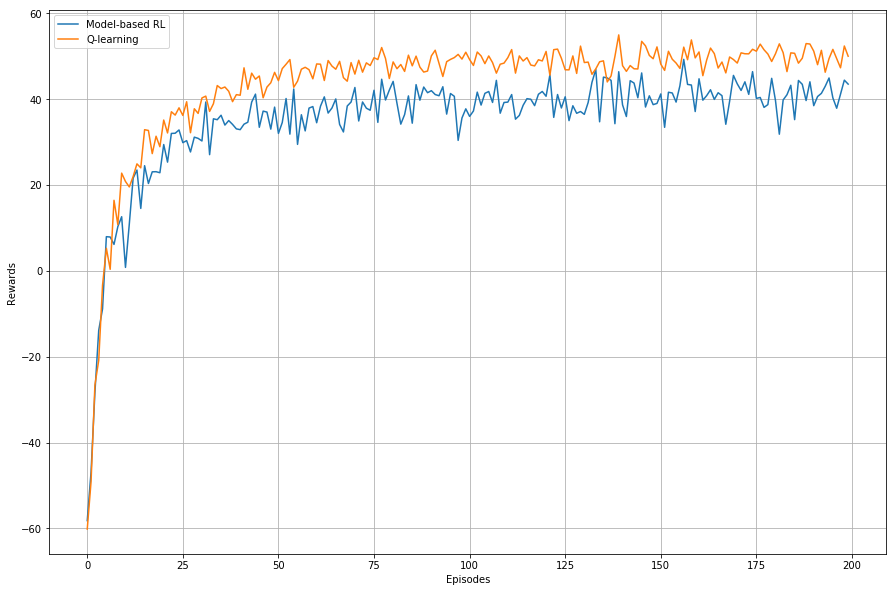

In [17]:
import pickle
Trials = 100

ax=plt.figure(figsize=(15,10))
plt.grid()
plt.xlabel("Episodes")
plt.ylabel("Rewards")

# Test model-based RL
cumu_ma_1 = []
start_time = time.time()
for iterTr in range(Trials):
    [V_1,policy_1,cumu_reward_1] = rlProblem.modelBasedRL(s0=0,defaultT=np.ones([mdp.nActions,mdp.nStates,mdp.nStates])/mdp.nStates,initialR=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=200,nSteps=100,epsilon=0.3)
    cumu_ma_1.append(cumu_reward_1)
print ("\nmodel-based RL results")
print ("V: ", V_1)
print ("Policy: ", policy_1)
print ("Time taken for each trial: ", (time.time() - start_time)/200)
plt.plot(list(range(200)), np.mean(cumu_ma_1,axis=0), label="Model-based RL")

# Test Q-learning
cumu_ma_2 = []
start_time = time.time()
for iterTr in range(Trials):
    [Q_2,policy_2,cumu_reward_2] = rlProblem.qLearning(s0=0,initialQ=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=200,nSteps=100,epsilon=0.05,temperature=1)
    cumu_ma_2.append(cumu_reward_2)
print ("\nQ-learning results")
print ("Q: ", Q_2)
print ("Policy: ", policy_2)
print ("Time taken for each trial: ", (time.time() - start_time)/200)
plt.plot(list(range(200)), np.mean(cumu_ma_2,axis=0), label="Q-learning")

plt.legend()


--------------------------------------------------

BayesModelBasedRL results
Q:  [[ -57.62809702   37.46772292  -44.82654079   48.14933621   48.84683948
   -47.91057231   21.147497     46.00856267   26.52268234 -121.44040293
    41.60115912  -56.84645445   27.34327053    5.77684165   31.12730514
   -47.84822808   30.55824026]
 [  33.35750948   35.50801976   39.92495581   36.01711612  -59.17243073
    29.75934871  -53.58039134   21.89142308   41.76716977  -34.43124462
    21.33336015  -60.52922749  -48.8338349    24.86740012    0.29528447
   -55.92268583  -62.1182569 ]
 [  43.34306242  -55.52626353   49.48875478  -42.96006375  -59.17881079
   -56.51835048   30.9262423   -48.68307197  -49.87299069  -35.41568748
   -52.46121922   35.8945595   -50.05821181   38.43836745   35.00409891
   -55.22090189   31.83474096]
 [ -60.41257151  -55.81900469  -55.71653039  -54.46014253   32.72187668
    38.93370418   42.26846026  -56.56166457   19.67049162  -49.4729526
    37.35922327   45.02676787   45

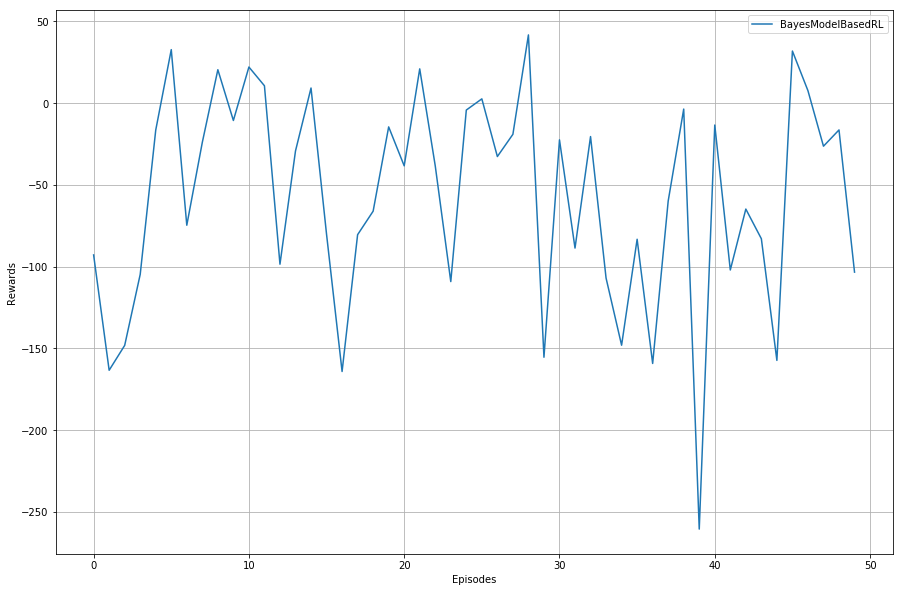

In [20]:
ax=plt.figure(figsize=(15,10))
plt.grid()
plt.xlabel("Episodes")
plt.ylabel("Rewards")

cumu_ma_3 = []
start_time = time.time()
for iterTr in range(1):
    [Q_3,policy_3,cumu_reward_3] = rlProblem.BayesModelBasedRL(s0=0,initialQ=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=50,nSteps=100,sim_nEpisodes=10,sim_nSteps=10,Sigma=1)
    cumu_ma_3.append(cumu_reward_3)
print ("\nBayesModelBasedRL results")
print ("Q: ", Q_3)
print ("Policy: ", policy_3)
print ("Time taken for each trial: ", (time.time() - start_time)/1)
plt.plot(list(range(50)), np.mean(cumu_ma_3,axis=0), label="BayesModelBasedRL")
plt.legend()

In [8]:
# with open('MazeRL.pkl','wb') as f:
#     pickle.dump(ax, f)
# plt.savefig("MazeRL.jpg")
# plt.show()

# with open("MazeRL.pkl",'rb') as f:
#     handle=pickle.load(f)
#     plt.plot(x,[z**2 for z in y])

In [9]:
import numpy as np
import keras
import tensorflow as tf
import gc
from keras.layers import Input, LSTM, Dense, Dropout
from keras.models import Model
from keras.utils import to_categorical as to_cat
tf.reset_default_graph()
gc.collect()
gpu_fraction = 0.5
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

class memory:
    def __init__(self,memory_size,belief_size,state_size,action_size):
        self.size=0
        self.memory_size=memory_size
        self.belief_size=belief_size
        self.state_size=state_size
        self.action_size=action_size
        self.mem_belief=np.empty([memory_size,self.belief_size])
        self.mem_state=np.empty([memory_size,self.state_size])
        self.mem_action=np.empty([memory_size,self.action_size])
        self.mem_reward=np.empty([memory_size,1])

    def push(self,belief,state,action,reward):
        if(self.size < self.memory_size):
            self.mem_belief[self.size]=belief
            self.mem_state[self.size]=state
            self.mem_action[self.size]=action
            self.mem_reward[self.size]=reward
            self.size+=1
        else:
            self.size=0
            self.mem_belief[self.size]=self.mem_belief[-1]
            self.mem_state[self.size]=self.mem_state[-1]
            self.mem_action[self.size]=self.mem_action[-1]
            self.mem_reward[self.size]=self.mem_reward[-1]
            self.size+=1
          
class SRL:

    def __init__(self,
                 belief_size,
                 state_size,
                 action_size,
                 mdp,
                 sampleReward):
        self.belief_size=belief_size
        self.state_size=state_size
        self.action_size=action_size
        self.mdp = mdp
        self.sampleReward = sampleReward
        
    def sampleRewardAndNextState(self,state,action):
        '''Procedure to sample a reward and the next state
        reward ~ Pr(r)
        nextState ~ Pr(s'|s,a)

        Inputs:
        state -- current state
        action -- action to be executed

        Outputs: 
        reward -- sampled reward
        nextState -- sampled next state
        '''

        reward = self.sampleReward(self.mdp.R[action,state])
        cumProb = np.cumsum(self.mdp.T[action,state,:])
        nextState = np.where(cumProb >= np.random.rand(1))[0][0]
        return [reward,nextState]

    def sampleAction(self,q):
        a = q - np.max(q)
        a = np.exp(a) / np.sum(np.exp(a))
        return np.where(np.cumsum(a) >= np.random.rand(1))[0][0]
        
    def sampleSoftmaxPolicy(self,policyParams,state):
        '''Procedure to sample an action from stochastic policy
        pi(a|s) = exp(policyParams(a,s))/[sum_a' exp(policyParams(a',s))])
        This function should be called by reinforce() to selection actions

        Inputs:
        policyParams -- parameters of a softmax policy (|A|x|S| array)
        state -- current state

        Outputs: 
        action -- sampled action
        '''

        # temporary value to ensure that the code compiles until this
        # function is coded
        pi = policyParams[:,state]
        pi = pi - np.max(pi)
        pi = np.exp(pi) / np.sum(np.exp(pi))
        action = np.where(np.cumsum(pi) >= np.random.rand(1))[0][0]
                          
        return action
    def build_model(self,
                    prefix,
                    batch_size,
                    RNN_type,
                    Dense_num_units,
                    Dropout_rate,
                    weight_state,
                    weight_reward,
                    Dense_num_units2,
                    Dropout_rate2,
                    weight_real):
        
        # build_Bayes_model
        Bayes_input_state = Input(shape=(1,self.state_size),
                                  batch_shape=(batch_size,1,self.state_size),
                                  dtype='float32',name=prefix+'Bayes_input_state')
        Bayes_input_action = Input(shape=(1,self.action_size),
                                   batch_shape=(batch_size,1,self.action_size),
                                   dtype='float32',name=prefix+'Bayes_input_action')
        Bayes_input = keras.layers.concatenate([Bayes_input_state,
                                                Bayes_input_action],axis=-1)
        if(RNN_type is LSTM):
            rnn = RNN_type(self.belief_size,
                           activity_regularizer=keras.regularizers.l2(-0.000001),
                           return_state=True,
                           stateful=True,
                           name=prefix+'LSTM')
            nnreset = getattr(rnn,'reset_states')
            [state_reward,_,belief]=rnn(Bayes_input)
            x_state = Dense(Dense_num_units,activation='tanh',
                            name=prefix+'LstmDenseState1B')(state_reward)
            x_state = Dropout(Dropout_rate,
                              name=prefix+'LstmDropoutState1B')(x_state)
            x_state = Dense(Dense_num_units,activation='tanh',
                            name=prefix+'LstmDenseState2B')(x_state)
            Bayes_output_state = Dense(self.state_size,activation='softmax',
                                       name=prefix+'Bayes_output_state')(x_state)
            
            x_reward = Dense(Dense_num_units,activation='tanh',
                             name=prefix+'LstmDenseReward1B')(state_reward)
            x_reward = Dropout(Dropout_rate,
                               name=prefix+'LstmDropoutReward1B')(x_reward)
            x_reward = Dense(Dense_num_units,activation='tanh',
                             name=prefix+'LstmDenseReward2B')(x_reward)
            Bayes_output_reward = Dense(1,activation='linear',
                                        name=prefix+'Bayes_output_reward')(x_reward)

        Bayes_model = Model(inputs=[Bayes_input_state,
                                    Bayes_input_action],
                            outputs=[belief,
                                     state_reward,
                                     Bayes_output_state,
                                     Bayes_output_reward])
        Bayes_model.compile(optimizer='rmsprop',
                           loss={prefix+'Bayes_output_state' : 'categorical_crossentropy',
                                 prefix+'Bayes_output_reward' : 'mean_squared_error'},
                           loss_weights={prefix+'Bayes_output_state' : weight_state,
                                         prefix+'Bayes_output_reward' : weight_reward},
                           metrics={prefix+'Bayes_output_state' : 'categorical_accuracy',
                                   prefix+'Bayes_output_reward' : 'mae'}
                           )
    
        # build_RL_model
        RL_input_belief = Input(shape=(self.belief_size,),
                                batch_shape=(batch_size,self.belief_size),
                                dtype='float32',name=prefix+'RL_input_belief')
        RL_input_state = Input(shape=(self.state_size,),
                               batch_shape=(batch_size,self.state_size),
                               dtype='float32',name=prefix+'RL_input_state')
        RL_input = keras.layers.concatenate([RL_input_belief,RL_input_state],axis=-1)
        x = Dense(Dense_num_units2,activation='tanh',
                  name=prefix+'RL_Dense1')(RL_input)
        x = Dense(Dense_num_units2,activation='tanh',
                  name=prefix+'RL_Dense2')(x)
        x = Dropout(Dropout_rate2,
                    name=prefix+'RL_Dropout1')(x)
        x = Dense(Dense_num_units2,activation='tanh',
                  name=prefix+'RL_Dense3')(x)
        x = Dense(Dense_num_units2,activation='tanh',
                  name=prefix+'RL_Dense4')(x)
        x = Dropout(Dropout_rate2,
                    name=prefix+'RL_Dropout2')(x)
        x = Dense(Dense_num_units2,activation='tanh',
                  name=prefix+'RL_Dense5')(x)
        x = Dense(Dense_num_units2,activation='tanh',
                  name=prefix+'RL_Dense6')(x)
        x = Dropout(Dropout_rate2,
                    name=prefix+'RL_Dropout3')(x)
        RL_Output = Dense(self.action_size,activation='softmax',
                          name=prefix+'RL_output_action')(x)
        RL_Model = Model(inputs=[RL_input_belief,RL_input_state],
                         outputs=RL_Output,name=prefix+"RL_Output")
        
        RL_model = Model(inputs=[RL_input_belief,
                                 RL_input_state],
                         outputs=RL_Model([RL_input_belief,RL_input_state]))
        RL_model.compile(optimizer='Adam',
                         loss=lambda y_true,y_pred : y_true)
        
        SRL_output = RL_Model([belief,RL_input_state])
        SRL_model = Model(inputs=[Bayes_input_state,
                                  Bayes_input_action,
                                  RL_input_state],
                         outputs=[SRL_output,
                                  belief,
                                  Bayes_output_state,
                                  Bayes_output_reward])
        SRL_model.compile(optimizer='rmsprop',
                          loss={prefix+'RL_Output' :
                                lambda y_true,y_pred : y_true,
                                prefix+'Bayes_output_state' : 'categorical_crossentropy',
                                prefix+'Bayes_output_reward' : 'mean_squared_error'},
                          loss_weights={
                              prefix+'RL_Output' : 
                              weight_real,
                              prefix+'Bayes_output_state' : 
                              weight_state/(1-weight_real),
                              prefix+'Bayes_output_reward' : 
                              weight_reward/(1-weight_real)},
                          )
        
        return [Bayes_model,RL_model,SRL_model,nnreset]
    
    # shuffle = False
        
    def SRLearn(self,memory_size,nEpisodes,nSteps,
                boot_epochs,boot_steps,update_steps):
        assert(boot_steps>=update_steps)
        args=[1,LSTM,50,0.1,0.999,0.001,100,0.1,0.8]
        real_mem=memory(memory_size,self.belief_size,self.state_size,self.action_size)
        [bayes,rl,srl,nnreset]=self.build_model('main_',*args)
        [bayes_t,rl_t,srl_t,nnreset_t]=self.build_model('target_',*args)
        iterEp=0
        # bootstrap
        init_belief=np.zeros([1,self.belief_size])
        init_state_reward=np.zeros([1,self.belief_size])
        init_h = [init_belief,init_state_reward]
        boot_mem=memory(boot_steps,self.belief_size,self.state_size,self.action_size)
        for it in range(boot_steps):
            s=np.random.randint(self.state_size)
            action=np.random.randint(self.action_size)
            [reward,s_next]=self.sampleRewardAndNextState(s,action)
            s=to_cat(s,self.state_size)
            action=to_cat(action,self.action_size)
            reward=np.array([reward])
            boot_mem.push(np.zeros(self.belief_size),s,action,reward)
            s=s_next
        for itEp in range(boot_epochs):
            print('Boot_Epochs:\t',itEp,'/',boot_epochs)
            nnreset(init_h)
            bayes.fit([boot_mem.mem_state[:-1].reshape([boot_steps-1,1,-1]),
                      boot_mem.mem_action[:-1].reshape([boot_steps-1,1,-1])],
                     [boot_mem.mem_state[1:].reshape([boot_steps-1,-1]),
                      boot_mem.mem_reward[:-1].reshape([boot_steps-1,-1])],
                      epochs=1,
                      batch_size=1)
        [boot_belief,boot_state_reward,_,_]=bayes.predict([boot_mem.mem_state[-1].reshape([1,1,-1]),
                                                          boot_mem.mem_action[-1].reshape([1,1,-1])])
        # Testing Bayes Model
        nnreset([boot_belief,boot_state_reward])
        print(boot_belief,boot_state_reward)
        count1=0
        for i in range(99):
            s=boot_mem.mem_state[i].reshape([1,1,-1])
            action=boot_mem.mem_action[i].reshape([1,1,-1])
            [_,__,s_n,reward]=bayes.predict([s,action])
            print(_)
            print('T',boot_mem.mem_state[i+1].argmax())
            print('P',s_n.argmax())
            if(boot_mem.mem_state[i+1].argmax()==s_n.argmax()):
                count1+=1
            print('T',boot_mem.mem_reward[i])
            print('P',reward)
        print('--------------------------------------------')
        nnreset(init_h)
        count2=0
        for i in range(99):
            s=boot_mem.mem_state[i].reshape([1,1,-1])
            action=boot_mem.mem_action[i].reshape([1,1,-1])
            [_,__,s_n,reward]=bayes.predict([s,action])
            print(_)
            print('T',boot_mem.mem_state[i+1].argmax())
            print('P',s_n.argmax())
            if(boot_mem.mem_state[i+1].argmax()==s_n.argmax()):
                count2+=1
            print('T',boot_mem.mem_reward[i])
            print('P',reward)
            
        print(count1,count2)
        
        while(iterEp < nEpisodes):
            iterEp+=1
            iterSt=0
            while(iterSt < nSteps):
                iterSt+=1
                pass
            

Using TensorFlow backend.


In [10]:
srlearn=SRL(100,17,4,mdp,np.random.normal)
srlearn.SRLearn(100,1,1,1000,100,1)

/home/haobei/Program/anaconda3/envs/AI/lib/python3.6/site-packages/ipykernel_launcher.py:154: UserWarning: Output "main_LSTM" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "main_LSTM" during training.
/home/haobei/Program/anaconda3/envs/AI/lib/python3.6/site-packages/ipykernel_launcher.py:213: UserWarning: Output "main_LSTM" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "main_LSTM" during training.
/home/haobei/Program/anaconda3/envs/AI/lib/python3.6/site-packages/ipykernel_launcher.py:154: UserWarning: Output "target_LSTM" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "target_LSTM" during training.
/home/haobei/Program/anaconda3/envs/AI/lib/python3.6/site-packages/ipykernel_launcher.py:213: UserWarning: Output "target_LSTM" missing from loss dictionary. We assume thi

Boot_Epochs:	 0 / 1000
Epoch 1/1
99/99 [==============================] - 1s 6ms/step - loss: 3.5524 - main_Bayes_output_state_loss: 2.8373 - main_Bayes_output_reward_loss: 718.0199 - main_Bayes_output_state_categorical_accuracy: 0.0505 - main_Bayes_output_reward_mean_absolute_error: 8.3594
Boot_Epochs:	 1 / 1000
Epoch 1/1
99/99 [==============================] - 0s 2ms/step - loss: 3.4970 - main_Bayes_output_state_loss: 2.7865 - main_Bayes_output_reward_loss: 713.2342 - main_Bayes_output_state_categorical_accuracy: 0.1212 - main_Bayes_output_reward_mean_absolute_error: 8.5090
Boot_Epochs:	 2 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 3.4634 - main_Bayes_output_state_loss: 2.7561 - main_Bayes_output_reward_loss: 710.0772 - main_Bayes_output_state_categorical_accuracy: 0.1414 - main_Bayes_output_reward_mean_absolute_error: 8.6457
Boot_Epochs:	 3 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 3.4436 - main_Bayes_output_sta

99/99 [==============================] - 0s 1ms/step - loss: 3.3049 - main_Bayes_output_state_loss: 2.6232 - main_Bayes_output_reward_loss: 684.4598 - main_Bayes_output_state_categorical_accuracy: 0.1313 - main_Bayes_output_reward_mean_absolute_error: 10.4428
Boot_Epochs:	 28 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 3.1972 - main_Bayes_output_state_loss: 2.5428 - main_Bayes_output_reward_loss: 657.1000 - main_Bayes_output_state_categorical_accuracy: 0.2222 - main_Bayes_output_reward_mean_absolute_error: 10.5545
Boot_Epochs:	 29 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 3.2042 - main_Bayes_output_state_loss: 2.5414 - main_Bayes_output_reward_loss: 665.4242 - main_Bayes_output_state_categorical_accuracy: 0.1414 - main_Bayes_output_reward_mean_absolute_error: 9.7675
Boot_Epochs:	 30 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 3.2794 - main_Bayes_output_state_loss: 2.6276 - main_Bayes

Boot_Epochs:	 55 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 3.1720 - main_Bayes_output_state_loss: 2.5024 - main_Bayes_output_reward_loss: 673.7655 - main_Bayes_output_state_categorical_accuracy: 0.2020 - main_Bayes_output_reward_mean_absolute_error: 10.1912
Boot_Epochs:	 56 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 3.2478 - main_Bayes_output_state_loss: 2.5786 - main_Bayes_output_reward_loss: 673.7986 - main_Bayes_output_state_categorical_accuracy: 0.1616 - main_Bayes_output_reward_mean_absolute_error: 10.3329
Boot_Epochs:	 57 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 3.1819 - main_Bayes_output_state_loss: 2.5347 - main_Bayes_output_reward_loss: 652.3153 - main_Bayes_output_state_categorical_accuracy: 0.2222 - main_Bayes_output_reward_mean_absolute_error: 9.6807
Boot_Epochs:	 58 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 3.1686 - main_Bayes_outp

99/99 [==============================] - 0s 1ms/step - loss: 3.1228 - main_Bayes_output_state_loss: 2.4953 - main_Bayes_output_reward_loss: 633.6508 - main_Bayes_output_state_categorical_accuracy: 0.1818 - main_Bayes_output_reward_mean_absolute_error: 9.3541
Boot_Epochs:	 83 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 3.2115 - main_Bayes_output_state_loss: 2.5855 - main_Bayes_output_reward_loss: 632.5417 - main_Bayes_output_state_categorical_accuracy: 0.1818 - main_Bayes_output_reward_mean_absolute_error: 9.9291
Boot_Epochs:	 84 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 3.0520 - main_Bayes_output_state_loss: 2.4480 - main_Bayes_output_reward_loss: 610.8146 - main_Bayes_output_state_categorical_accuracy: 0.2121 - main_Bayes_output_reward_mean_absolute_error: 9.6480
Boot_Epochs:	 85 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 3.1579 - main_Bayes_output_state_loss: 2.5181 - main_Bayes_o

99/99 [==============================] - 0s 1ms/step - loss: 2.8650 - main_Bayes_output_state_loss: 2.3965 - main_Bayes_output_reward_loss: 481.7427 - main_Bayes_output_state_categorical_accuracy: 0.1919 - main_Bayes_output_reward_mean_absolute_error: 9.3511
Boot_Epochs:	 111 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 2.8769 - main_Bayes_output_state_loss: 2.3904 - main_Bayes_output_reward_loss: 500.0656 - main_Bayes_output_state_categorical_accuracy: 0.2222 - main_Bayes_output_reward_mean_absolute_error: 8.0108
Boot_Epochs:	 112 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 2.9364 - main_Bayes_output_state_loss: 2.4681 - main_Bayes_output_reward_loss: 482.5996 - main_Bayes_output_state_categorical_accuracy: 0.2020 - main_Bayes_output_reward_mean_absolute_error: 9.0513
Boot_Epochs:	 113 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 2.8647 - main_Bayes_output_state_loss: 2.3636 - main_Baye

99/99 [==============================] - 0s 1ms/step - loss: 2.7886 - main_Bayes_output_state_loss: 2.3386 - main_Bayes_output_reward_loss: 472.9171 - main_Bayes_output_state_categorical_accuracy: 0.2626 - main_Bayes_output_reward_mean_absolute_error: 8.2648
Boot_Epochs:	 138 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 2.8546 - main_Bayes_output_state_loss: 2.4498 - main_Bayes_output_reward_loss: 429.2149 - main_Bayes_output_state_categorical_accuracy: 0.1212 - main_Bayes_output_reward_mean_absolute_error: 7.5594
Boot_Epochs:	 139 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 2.7305 - main_Bayes_output_state_loss: 2.3590 - main_Bayes_output_reward_loss: 396.4529 - main_Bayes_output_state_categorical_accuracy: 0.2424 - main_Bayes_output_reward_mean_absolute_error: 7.4870
Boot_Epochs:	 140 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 2.6532 - main_Bayes_output_state_loss: 2.3001 - main_Baye

99/99 [==============================] - 0s 1ms/step - loss: 2.4966 - main_Bayes_output_state_loss: 2.2445 - main_Bayes_output_reward_loss: 299.8200 - main_Bayes_output_state_categorical_accuracy: 0.2626 - main_Bayes_output_reward_mean_absolute_error: 6.5101
Boot_Epochs:	 165 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 2.5894 - main_Bayes_output_state_loss: 2.2874 - main_Bayes_output_reward_loss: 349.8444 - main_Bayes_output_state_categorical_accuracy: 0.2929 - main_Bayes_output_reward_mean_absolute_error: 6.2913
Boot_Epochs:	 166 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 2.4057 - main_Bayes_output_state_loss: 2.1718 - main_Bayes_output_reward_loss: 280.5126 - main_Bayes_output_state_categorical_accuracy: 0.2727 - main_Bayes_output_reward_mean_absolute_error: 6.4727
Boot_Epochs:	 167 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 2.3963 - main_Bayes_output_state_loss: 2.2033 - main_Baye

99/99 [==============================] - 0s 1ms/step - loss: 2.3697 - main_Bayes_output_state_loss: 2.1816 - main_Bayes_output_reward_loss: 258.4805 - main_Bayes_output_state_categorical_accuracy: 0.2828 - main_Bayes_output_reward_mean_absolute_error: 5.3869
Boot_Epochs:	 192 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 2.3711 - main_Bayes_output_state_loss: 2.2149 - main_Bayes_output_reward_loss: 230.0235 - main_Bayes_output_state_categorical_accuracy: 0.2626 - main_Bayes_output_reward_mean_absolute_error: 5.3662
Boot_Epochs:	 193 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 2.3131 - main_Bayes_output_state_loss: 2.2280 - main_Bayes_output_reward_loss: 159.0466 - main_Bayes_output_state_categorical_accuracy: 0.2626 - main_Bayes_output_reward_mean_absolute_error: 4.4402
Boot_Epochs:	 194 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 2.2843 - main_Bayes_output_state_loss: 2.1680 - main_Baye

99/99 [==============================] - 0s 1ms/step - loss: 2.0699 - main_Bayes_output_state_loss: 2.0438 - main_Bayes_output_reward_loss: 117.8226 - main_Bayes_output_state_categorical_accuracy: 0.3232 - main_Bayes_output_reward_mean_absolute_error: 3.4800
Boot_Epochs:	 219 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 2.0105 - main_Bayes_output_state_loss: 2.0592 - main_Bayes_output_reward_loss: 43.0798 - main_Bayes_output_state_categorical_accuracy: 0.3737 - main_Bayes_output_reward_mean_absolute_error: 2.7004
Boot_Epochs:	 220 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 2.2573 - main_Bayes_output_state_loss: 2.0919 - main_Bayes_output_reward_loss: 257.6989 - main_Bayes_output_state_categorical_accuracy: 0.2727 - main_Bayes_output_reward_mean_absolute_error: 4.8889
Boot_Epochs:	 221 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.9886 - main_Bayes_output_state_loss: 2.0491 - main_Bayes

99/99 [==============================] - 0s 1ms/step - loss: 1.8590 - main_Bayes_output_state_loss: 1.9034 - main_Bayes_output_reward_loss: 79.9935 - main_Bayes_output_state_categorical_accuracy: 0.3737 - main_Bayes_output_reward_mean_absolute_error: 2.5556
Boot_Epochs:	 247 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.9488 - main_Bayes_output_state_loss: 1.9275 - main_Bayes_output_reward_loss: 146.9199 - main_Bayes_output_state_categorical_accuracy: 0.3535 - main_Bayes_output_reward_mean_absolute_error: 3.4318
Boot_Epochs:	 248 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 2.0278 - main_Bayes_output_state_loss: 1.9557 - main_Bayes_output_reward_loss: 199.0466 - main_Bayes_output_state_categorical_accuracy: 0.2929 - main_Bayes_output_reward_mean_absolute_error: 4.1699
Boot_Epochs:	 249 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.7841 - main_Bayes_output_state_loss: 1.8586 - main_Bayes

99/99 [==============================] - 0s 1ms/step - loss: 1.7231 - main_Bayes_output_state_loss: 1.7882 - main_Bayes_output_reward_loss: 71.9761 - main_Bayes_output_state_categorical_accuracy: 0.3535 - main_Bayes_output_reward_mean_absolute_error: 2.2666
Boot_Epochs:	 275 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.6942 - main_Bayes_output_state_loss: 1.7639 - main_Bayes_output_reward_loss: 67.0698 - main_Bayes_output_state_categorical_accuracy: 0.4242 - main_Bayes_output_reward_mean_absolute_error: 2.3396
Boot_Epochs:	 276 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.7434 - main_Bayes_output_state_loss: 1.8246 - main_Bayes_output_reward_loss: 56.0547 - main_Bayes_output_state_categorical_accuracy: 0.3737 - main_Bayes_output_reward_mean_absolute_error: 1.8051
Boot_Epochs:	 277 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.7455 - main_Bayes_output_state_loss: 1.7835 - main_Bayes_o

99/99 [==============================] - 0s 1ms/step - loss: 1.5845 - main_Bayes_output_state_loss: 1.7017 - main_Bayes_output_reward_loss: 23.1264 - main_Bayes_output_state_categorical_accuracy: 0.4141 - main_Bayes_output_reward_mean_absolute_error: 1.6004
Boot_Epochs:	 303 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.6168 - main_Bayes_output_state_loss: 1.6631 - main_Bayes_output_reward_loss: 94.8437 - main_Bayes_output_state_categorical_accuracy: 0.4242 - main_Bayes_output_reward_mean_absolute_error: 2.5291
Boot_Epochs:	 304 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.7934 - main_Bayes_output_state_loss: 1.7893 - main_Bayes_output_reward_loss: 146.5440 - main_Bayes_output_state_categorical_accuracy: 0.3636 - main_Bayes_output_reward_mean_absolute_error: 2.9804
Boot_Epochs:	 305 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.6564 - main_Bayes_output_state_loss: 1.6884 - main_Bayes_

99/99 [==============================] - 0s 1ms/step - loss: 1.5766 - main_Bayes_output_state_loss: 1.6596 - main_Bayes_output_reward_loss: 77.3331 - main_Bayes_output_state_categorical_accuracy: 0.4747 - main_Bayes_output_reward_mean_absolute_error: 2.0034
Boot_Epochs:	 331 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.5168 - main_Bayes_output_state_loss: 1.5922 - main_Bayes_output_reward_loss: 85.6741 - main_Bayes_output_state_categorical_accuracy: 0.4949 - main_Bayes_output_reward_mean_absolute_error: 2.2794
Boot_Epochs:	 332 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.5442 - main_Bayes_output_state_loss: 1.6407 - main_Bayes_output_reward_loss: 64.6404 - main_Bayes_output_state_categorical_accuracy: 0.4242 - main_Bayes_output_reward_mean_absolute_error: 1.8631
Boot_Epochs:	 333 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.4978 - main_Bayes_output_state_loss: 1.6576 - main_Bayes_o

99/99 [==============================] - 0s 1ms/step - loss: 1.4709 - main_Bayes_output_state_loss: 1.6093 - main_Bayes_output_reward_loss: 31.6328 - main_Bayes_output_state_categorical_accuracy: 0.4242 - main_Bayes_output_reward_mean_absolute_error: 1.4652
Boot_Epochs:	 359 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.3583 - main_Bayes_output_state_loss: 1.5202 - main_Bayes_output_reward_loss: 9.2379 - main_Bayes_output_state_categorical_accuracy: 0.4545 - main_Bayes_output_reward_mean_absolute_error: 1.2541
Boot_Epochs:	 360 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.4466 - main_Bayes_output_state_loss: 1.5657 - main_Bayes_output_reward_loss: 52.1737 - main_Bayes_output_state_categorical_accuracy: 0.4343 - main_Bayes_output_reward_mean_absolute_error: 1.9613
Boot_Epochs:	 361 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.4461 - main_Bayes_output_state_loss: 1.5169 - main_Bayes_ou

99/99 [==============================] - 0s 1ms/step - loss: 1.3574 - main_Bayes_output_state_loss: 1.4781 - main_Bayes_output_reward_loss: 64.4381 - main_Bayes_output_state_categorical_accuracy: 0.4747 - main_Bayes_output_reward_mean_absolute_error: 2.1923
Boot_Epochs:	 387 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.4146 - main_Bayes_output_state_loss: 1.5933 - main_Bayes_output_reward_loss: 7.7512 - main_Bayes_output_state_categorical_accuracy: 0.4444 - main_Bayes_output_reward_mean_absolute_error: 1.1700
Boot_Epochs:	 388 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.3885 - main_Bayes_output_state_loss: 1.4867 - main_Bayes_output_reward_loss: 87.7079 - main_Bayes_output_state_categorical_accuracy: 0.4444 - main_Bayes_output_reward_mean_absolute_error: 2.2894
Boot_Epochs:	 389 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.4525 - main_Bayes_output_state_loss: 1.5278 - main_Bayes_ou

99/99 [==============================] - 0s 1ms/step - loss: 1.3380 - main_Bayes_output_state_loss: 1.4802 - main_Bayes_output_reward_loss: 47.8054 - main_Bayes_output_state_categorical_accuracy: 0.4444 - main_Bayes_output_reward_mean_absolute_error: 1.5809
Boot_Epochs:	 415 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.3831 - main_Bayes_output_state_loss: 1.5146 - main_Bayes_output_reward_loss: 57.7729 - main_Bayes_output_state_categorical_accuracy: 0.4646 - main_Bayes_output_reward_mean_absolute_error: 2.0048
Boot_Epochs:	 416 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.4354 - main_Bayes_output_state_loss: 1.5208 - main_Bayes_output_reward_loss: 104.9101 - main_Bayes_output_state_categorical_accuracy: 0.4040 - main_Bayes_output_reward_mean_absolute_error: 2.5282
Boot_Epochs:	 417 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.2616 - main_Bayes_output_state_loss: 1.4273 - main_Bayes_

99/99 [==============================] - 0s 1ms/step - loss: 1.2465 - main_Bayes_output_state_loss: 1.3753 - main_Bayes_output_reward_loss: 62.3111 - main_Bayes_output_state_categorical_accuracy: 0.4949 - main_Bayes_output_reward_mean_absolute_error: 1.8805
Boot_Epochs:	 443 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.2172 - main_Bayes_output_state_loss: 1.3568 - main_Bayes_output_reward_loss: 53.9548 - main_Bayes_output_state_categorical_accuracy: 0.4646 - main_Bayes_output_reward_mean_absolute_error: 1.7973
Boot_Epochs:	 444 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.2403 - main_Bayes_output_state_loss: 1.4230 - main_Bayes_output_reward_loss: 11.2799 - main_Bayes_output_state_categorical_accuracy: 0.4646 - main_Bayes_output_reward_mean_absolute_error: 1.3547
Boot_Epochs:	 445 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.3059 - main_Bayes_output_state_loss: 1.4542 - main_Bayes_o

99/99 [==============================] - 0s 1ms/step - loss: 1.2727 - main_Bayes_output_state_loss: 1.4203 - main_Bayes_output_reward_loss: 61.2801 - main_Bayes_output_state_categorical_accuracy: 0.4545 - main_Bayes_output_reward_mean_absolute_error: 2.0540
Boot_Epochs:	 471 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.2735 - main_Bayes_output_state_loss: 1.4681 - main_Bayes_output_reward_loss: 14.1607 - main_Bayes_output_state_categorical_accuracy: 0.4343 - main_Bayes_output_reward_mean_absolute_error: 1.5279
Boot_Epochs:	 472 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.1643 - main_Bayes_output_state_loss: 1.3249 - main_Bayes_output_reward_loss: 45.5510 - main_Bayes_output_state_categorical_accuracy: 0.4949 - main_Bayes_output_reward_mean_absolute_error: 2.0056
Boot_Epochs:	 473 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.1653 - main_Bayes_output_state_loss: 1.3657 - main_Bayes_o

99/99 [==============================] - 0s 1ms/step - loss: 1.2543 - main_Bayes_output_state_loss: 1.4250 - main_Bayes_output_reward_loss: 52.0664 - main_Bayes_output_state_categorical_accuracy: 0.5152 - main_Bayes_output_reward_mean_absolute_error: 1.7597
Boot_Epochs:	 499 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.1543 - main_Bayes_output_state_loss: 1.3378 - main_Bayes_output_reward_loss: 40.9090 - main_Bayes_output_state_categorical_accuracy: 0.4949 - main_Bayes_output_reward_mean_absolute_error: 1.5012
Boot_Epochs:	 500 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.1807 - main_Bayes_output_state_loss: 1.3533 - main_Bayes_output_reward_loss: 51.5563 - main_Bayes_output_state_categorical_accuracy: 0.4949 - main_Bayes_output_reward_mean_absolute_error: 1.7753
Boot_Epochs:	 501 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.1668 - main_Bayes_output_state_loss: 1.3733 - main_Bayes_o

99/99 [==============================] - 0s 1ms/step - loss: 1.2227 - main_Bayes_output_state_loss: 1.4384 - main_Bayes_output_reward_loss: 14.0896 - main_Bayes_output_state_categorical_accuracy: 0.5152 - main_Bayes_output_reward_mean_absolute_error: 1.2617
Boot_Epochs:	 527 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.1648 - main_Bayes_output_state_loss: 1.3926 - main_Bayes_output_reward_loss: 1.9809 - main_Bayes_output_state_categorical_accuracy: 0.4545 - main_Bayes_output_reward_mean_absolute_error: 0.8783
Boot_Epochs:	 528 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.1247 - main_Bayes_output_state_loss: 1.3013 - main_Bayes_output_reward_loss: 51.6423 - main_Bayes_output_state_categorical_accuracy: 0.5152 - main_Bayes_output_reward_mean_absolute_error: 1.7352
Boot_Epochs:	 529 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.2761 - main_Bayes_output_state_loss: 1.4301 - main_Bayes_ou

99/99 [==============================] - 0s 1ms/step - loss: 1.1096 - main_Bayes_output_state_loss: 1.2974 - main_Bayes_output_reward_loss: 41.2972 - main_Bayes_output_state_categorical_accuracy: 0.5051 - main_Bayes_output_reward_mean_absolute_error: 1.7962
Boot_Epochs:	 555 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.2597 - main_Bayes_output_state_loss: 1.3668 - main_Bayes_output_reward_loss: 122.3833 - main_Bayes_output_state_categorical_accuracy: 0.4343 - main_Bayes_output_reward_mean_absolute_error: 2.6170
Boot_Epochs:	 556 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.2077 - main_Bayes_output_state_loss: 1.4307 - main_Bayes_output_reward_loss: 6.6084 - main_Bayes_output_state_categorical_accuracy: 0.4343 - main_Bayes_output_reward_mean_absolute_error: 1.1172
Boot_Epochs:	 557 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.1933 - main_Bayes_output_state_loss: 1.4121 - main_Bayes_o

99/99 [==============================] - 0s 1ms/step - loss: 1.0816 - main_Bayes_output_state_loss: 1.2712 - main_Bayes_output_reward_loss: 53.0184 - main_Bayes_output_state_categorical_accuracy: 0.5051 - main_Bayes_output_reward_mean_absolute_error: 1.5008
Boot_Epochs:	 583 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.0586 - main_Bayes_output_state_loss: 1.2847 - main_Bayes_output_reward_loss: 17.0274 - main_Bayes_output_state_categorical_accuracy: 0.5152 - main_Bayes_output_reward_mean_absolute_error: 1.2779
Boot_Epochs:	 584 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.1515 - main_Bayes_output_state_loss: 1.3916 - main_Bayes_output_reward_loss: 3.2198 - main_Bayes_output_state_categorical_accuracy: 0.4141 - main_Bayes_output_reward_mean_absolute_error: 0.9249
Boot_Epochs:	 585 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.1347 - main_Bayes_output_state_loss: 1.3717 - main_Bayes_ou

99/99 [==============================] - 0s 1ms/step - loss: 1.1723 - main_Bayes_output_state_loss: 1.3910 - main_Bayes_output_reward_loss: 30.5783 - main_Bayes_output_state_categorical_accuracy: 0.4343 - main_Bayes_output_reward_mean_absolute_error: 1.4307
Boot_Epochs:	 611 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.1061 - main_Bayes_output_state_loss: 1.3392 - main_Bayes_output_reward_loss: 15.0336 - main_Bayes_output_state_categorical_accuracy: 0.4848 - main_Bayes_output_reward_mean_absolute_error: 1.1114
Boot_Epochs:	 612 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.0929 - main_Bayes_output_state_loss: 1.3343 - main_Bayes_output_reward_loss: 7.0912 - main_Bayes_output_state_categorical_accuracy: 0.4545 - main_Bayes_output_reward_mean_absolute_error: 1.0556
Boot_Epochs:	 613 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.0848 - main_Bayes_output_state_loss: 1.3149 - main_Bayes_ou

99/99 [==============================] - 0s 1ms/step - loss: 1.1477 - main_Bayes_output_state_loss: 1.3716 - main_Bayes_output_reward_loss: 27.5641 - main_Bayes_output_state_categorical_accuracy: 0.4444 - main_Bayes_output_reward_mean_absolute_error: 1.3130
Boot_Epochs:	 639 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.0761 - main_Bayes_output_state_loss: 1.3186 - main_Bayes_output_reward_loss: 9.9425 - main_Bayes_output_state_categorical_accuracy: 0.4545 - main_Bayes_output_reward_mean_absolute_error: 1.0668
Boot_Epochs:	 640 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.1704 - main_Bayes_output_state_loss: 1.4228 - main_Bayes_output_reward_loss: 0.7852 - main_Bayes_output_state_categorical_accuracy: 0.4747 - main_Bayes_output_reward_mean_absolute_error: 0.7364
Boot_Epochs:	 641 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.1316 - main_Bayes_output_state_loss: 1.3690 - main_Bayes_out

99/99 [==============================] - 0s 1ms/step - loss: 1.0956 - main_Bayes_output_state_loss: 1.3213 - main_Bayes_output_reward_loss: 30.7662 - main_Bayes_output_state_categorical_accuracy: 0.5354 - main_Bayes_output_reward_mean_absolute_error: 1.5798
Boot_Epochs:	 667 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.1000 - main_Bayes_output_state_loss: 1.3478 - main_Bayes_output_reward_loss: 9.2891 - main_Bayes_output_state_categorical_accuracy: 0.5051 - main_Bayes_output_reward_mean_absolute_error: 1.0856
Boot_Epochs:	 668 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.1190 - main_Bayes_output_state_loss: 1.3740 - main_Bayes_output_reward_loss: 0.8410 - main_Bayes_output_state_categorical_accuracy: 0.4343 - main_Bayes_output_reward_mean_absolute_error: 0.7479
Boot_Epochs:	 669 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.0870 - main_Bayes_output_state_loss: 1.3336 - main_Bayes_out

99/99 [==============================] - 0s 1ms/step - loss: 1.2860 - main_Bayes_output_state_loss: 1.4975 - main_Bayes_output_reward_loss: 44.7818 - main_Bayes_output_state_categorical_accuracy: 0.3737 - main_Bayes_output_reward_mean_absolute_error: 1.4450
Boot_Epochs:	 695 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.0709 - main_Bayes_output_state_loss: 1.3249 - main_Bayes_output_reward_loss: 1.3691 - main_Bayes_output_state_categorical_accuracy: 0.4747 - main_Bayes_output_reward_mean_absolute_error: 0.8190
Boot_Epochs:	 696 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.1604 - main_Bayes_output_state_loss: 1.3663 - main_Bayes_output_reward_loss: 49.9326 - main_Bayes_output_state_categorical_accuracy: 0.4646 - main_Bayes_output_reward_mean_absolute_error: 1.7284
Boot_Epochs:	 697 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 0.9434 - main_Bayes_output_state_loss: 1.1991 - main_Bayes_ou

99/99 [==============================] - 0s 1ms/step - loss: 1.0422 - main_Bayes_output_state_loss: 1.2973 - main_Bayes_output_reward_loss: 0.8041 - main_Bayes_output_state_categorical_accuracy: 0.4848 - main_Bayes_output_reward_mean_absolute_error: 0.7339
Boot_Epochs:	 723 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.1115 - main_Bayes_output_state_loss: 1.3671 - main_Bayes_output_reward_loss: 0.8314 - main_Bayes_output_state_categorical_accuracy: 0.4242 - main_Bayes_output_reward_mean_absolute_error: 0.7050
Boot_Epochs:	 724 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.0358 - main_Bayes_output_state_loss: 1.2514 - main_Bayes_output_reward_loss: 40.0533 - main_Bayes_output_state_categorical_accuracy: 0.5354 - main_Bayes_output_reward_mean_absolute_error: 1.5904
Boot_Epochs:	 725 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.0267 - main_Bayes_output_state_loss: 1.1924 - main_Bayes_out

99/99 [==============================] - 0s 1ms/step - loss: 1.1882 - main_Bayes_output_state_loss: 1.4241 - main_Bayes_output_reward_loss: 20.1486 - main_Bayes_output_state_categorical_accuracy: 0.4343 - main_Bayes_output_reward_mean_absolute_error: 1.3227
Boot_Epochs:	 751 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.1368 - main_Bayes_output_state_loss: 1.3809 - main_Bayes_output_reward_loss: 12.7733 - main_Bayes_output_state_categorical_accuracy: 0.4444 - main_Bayes_output_reward_mean_absolute_error: 1.2093
Boot_Epochs:	 752 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.1197 - main_Bayes_output_state_loss: 1.3757 - main_Bayes_output_reward_loss: 1.2759 - main_Bayes_output_state_categorical_accuracy: 0.4949 - main_Bayes_output_reward_mean_absolute_error: 0.8138
Boot_Epochs:	 753 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.0549 - main_Bayes_output_state_loss: 1.3099 - main_Bayes_ou

99/99 [==============================] - 0s 1ms/step - loss: 1.1329 - main_Bayes_output_state_loss: 1.3444 - main_Bayes_output_reward_loss: 46.2878 - main_Bayes_output_state_categorical_accuracy: 0.4646 - main_Bayes_output_reward_mean_absolute_error: 1.4548
Boot_Epochs:	 779 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.0987 - main_Bayes_output_state_loss: 1.2978 - main_Bayes_output_reward_loss: 58.4501 - main_Bayes_output_state_categorical_accuracy: 0.4848 - main_Bayes_output_reward_mean_absolute_error: 1.8825
Boot_Epochs:	 780 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.1784 - main_Bayes_output_state_loss: 1.4319 - main_Bayes_output_reward_loss: 6.2061 - main_Bayes_output_state_categorical_accuracy: 0.3939 - main_Bayes_output_reward_mean_absolute_error: 1.1478
Boot_Epochs:	 781 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.4408 - main_Bayes_output_state_loss: 1.4679 - main_Bayes_ou

Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.1872 - main_Bayes_output_state_loss: 1.3684 - main_Bayes_output_reward_loss: 84.9563 - main_Bayes_output_state_categorical_accuracy: 0.4545 - main_Bayes_output_reward_mean_absolute_error: 2.0449
Boot_Epochs:	 807 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.2141 - main_Bayes_output_state_loss: 1.3567 - main_Bayes_output_reward_loss: 122.0070 - main_Bayes_output_state_categorical_accuracy: 0.4848 - main_Bayes_output_reward_mean_absolute_error: 2.3012
Boot_Epochs:	 808 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.0622 - main_Bayes_output_state_loss: 1.3248 - main_Bayes_output_reward_loss: 1.9257 - main_Bayes_output_state_categorical_accuracy: 0.4444 - main_Bayes_output_reward_mean_absolute_error: 0.9294
Boot_Epochs:	 809 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.1257 - main_Bayes_output_state_loss: 1.3573 - ma

99/99 [==============================] - 0s 1ms/step - loss: 1.0810 - main_Bayes_output_state_loss: 1.2487 - main_Bayes_output_reward_loss: 97.3726 - main_Bayes_output_state_categorical_accuracy: 0.5354 - main_Bayes_output_reward_mean_absolute_error: 2.2466
Boot_Epochs:	 835 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.1584 - main_Bayes_output_state_loss: 1.4239 - main_Bayes_output_reward_loss: 0.9370 - main_Bayes_output_state_categorical_accuracy: 0.4848 - main_Bayes_output_reward_mean_absolute_error: 0.7857
Boot_Epochs:	 836 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.0216 - main_Bayes_output_state_loss: 1.2860 - main_Bayes_output_reward_loss: 1.6272 - main_Bayes_output_state_categorical_accuracy: 0.5051 - main_Bayes_output_reward_mean_absolute_error: 0.8224
Boot_Epochs:	 837 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.1764 - main_Bayes_output_state_loss: 1.4060 - main_Bayes_out

99/99 [==============================] - 0s 1ms/step - loss: 1.2798 - main_Bayes_output_state_loss: 1.3043 - main_Bayes_output_reward_loss: 244.1892 - main_Bayes_output_state_categorical_accuracy: 0.4747 - main_Bayes_output_reward_mean_absolute_error: 3.9780
Boot_Epochs:	 863 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.0719 - main_Bayes_output_state_loss: 1.3323 - main_Bayes_output_reward_loss: 8.0102 - main_Bayes_output_state_categorical_accuracy: 0.4747 - main_Bayes_output_reward_mean_absolute_error: 0.9935
Boot_Epochs:	 864 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.0717 - main_Bayes_output_state_loss: 1.3382 - main_Bayes_output_reward_loss: 2.4302 - main_Bayes_output_state_categorical_accuracy: 0.5051 - main_Bayes_output_reward_mean_absolute_error: 0.8520
Boot_Epochs:	 865 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.0749 - main_Bayes_output_state_loss: 1.3273 - main_Bayes_ou

99/99 [==============================] - 0s 1ms/step - loss: 0.9617 - main_Bayes_output_state_loss: 1.2040 - main_Bayes_output_reward_loss: 28.1174 - main_Bayes_output_state_categorical_accuracy: 0.5152 - main_Bayes_output_reward_mean_absolute_error: 1.5288
Boot_Epochs:	 891 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.1638 - main_Bayes_output_state_loss: 1.3463 - main_Bayes_output_reward_loss: 88.0751 - main_Bayes_output_state_categorical_accuracy: 0.4444 - main_Bayes_output_reward_mean_absolute_error: 2.1167
Boot_Epochs:	 892 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.0444 - main_Bayes_output_state_loss: 1.2299 - main_Bayes_output_reward_loss: 83.9431 - main_Bayes_output_state_categorical_accuracy: 0.4444 - main_Bayes_output_reward_mean_absolute_error: 2.2648
Boot_Epochs:	 893 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.0329 - main_Bayes_output_state_loss: 1.2781 - main_Bayes_o

99/99 [==============================] - 0s 1ms/step - loss: 1.1711 - main_Bayes_output_state_loss: 1.3741 - main_Bayes_output_reward_loss: 72.9681 - main_Bayes_output_state_categorical_accuracy: 0.4141 - main_Bayes_output_reward_mean_absolute_error: 2.2093
Boot_Epochs:	 919 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.2567 - main_Bayes_output_state_loss: 1.3780 - main_Bayes_output_reward_loss: 153.5619 - main_Bayes_output_state_categorical_accuracy: 0.4343 - main_Bayes_output_reward_mean_absolute_error: 3.0834
Boot_Epochs:	 920 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.1515 - main_Bayes_output_state_loss: 1.3758 - main_Bayes_output_reward_loss: 50.8013 - main_Bayes_output_state_categorical_accuracy: 0.4646 - main_Bayes_output_reward_mean_absolute_error: 1.6930
Boot_Epochs:	 921 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.1043 - main_Bayes_output_state_loss: 1.3420 - main_Bayes_

99/99 [==============================] - 0s 1ms/step - loss: 1.1809 - main_Bayes_output_state_loss: 1.4374 - main_Bayes_output_reward_loss: 18.5126 - main_Bayes_output_state_categorical_accuracy: 0.4545 - main_Bayes_output_reward_mean_absolute_error: 1.3418
Boot_Epochs:	 947 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.1789 - main_Bayes_output_state_loss: 1.3000 - main_Bayes_output_reward_loss: 153.1211 - main_Bayes_output_state_categorical_accuracy: 0.5152 - main_Bayes_output_reward_mean_absolute_error: 2.8278
Boot_Epochs:	 948 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.1358 - main_Bayes_output_state_loss: 1.3633 - main_Bayes_output_reward_loss: 48.3860 - main_Bayes_output_state_categorical_accuracy: 0.4343 - main_Bayes_output_reward_mean_absolute_error: 1.6836
Boot_Epochs:	 949 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.0325 - main_Bayes_output_state_loss: 1.3068 - main_Bayes_

99/99 [==============================] - 0s 1ms/step - loss: 1.2617 - main_Bayes_output_state_loss: 1.4971 - main_Bayes_output_reward_loss: 50.9204 - main_Bayes_output_state_categorical_accuracy: 0.4646 - main_Bayes_output_reward_mean_absolute_error: 2.2858
Boot_Epochs:	 975 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.4340 - main_Bayes_output_state_loss: 1.5178 - main_Bayes_output_reward_loss: 198.4160 - main_Bayes_output_state_categorical_accuracy: 0.4848 - main_Bayes_output_reward_mean_absolute_error: 3.5656
Boot_Epochs:	 976 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.1924 - main_Bayes_output_state_loss: 1.3796 - main_Bayes_output_reward_loss: 95.1794 - main_Bayes_output_state_categorical_accuracy: 0.4545 - main_Bayes_output_reward_mean_absolute_error: 2.6455
Boot_Epochs:	 977 / 1000
Epoch 1/1
99/99 [==============================] - 0s 1ms/step - loss: 1.1843 - main_Bayes_output_state_loss: 1.4243 - main_Bayes_

[[-33.08027    -33.999996    33.999996   -33.906578   -33.
   33.          33.335968    33.9999     -33.99874    -33.999996
   34.          -0.99767065  33.878513    34.         -34.
  -33.791157    32.99992     33.99949     -0.9998137   34.
  -33.          32.99999     33.39419    -32.999985   -34.
   33.          34.          34.          34.         -33.240944
  -33.1633     -33.          -1.4072325   33.999992   -33.999996
   32.99996     33.999954   -33.999664    32.999893    33.311584
  -33.999165    -1.1607417   34.         -33.140625   -32.99996
   33.999912   -33.          33.         -32.999992    -1.1353154
   33.734764    33.958366   -33.99991     33.552006    -0.13092557
   32.99982     32.999985    34.          34.          33.902943
  -33.99981    -33.999992    33.94656     33.         -32.999977
  -33.99999    -33.          34.          -1.8626256   34.
  -32.999996   -33.99987     33.          32.99961     33.510216
   33.999985   -34.          33.999977   -33.        

[[-65.08027   -66.         66.        -65.90658   -65.         65.
   65.33597    65.99974   -65.99854   -66.         66.         -0.9999999
   65.87837    66.        -66.        -65.79115    64.99987    65.99904
   -0.8457094  66.        -65.         64.99998    65.39364   -64.999985
  -66.         65.         66.         66.         66.        -65.240944
  -65.1633    -65.         -1.4080774  65.99996   -65.99999    64.99994
   65.99994   -65.999405   64.99984    65.311584  -65.999115   -0.9998942
   66.        -65.140625  -64.999916   65.99991   -65.         65.
  -64.99999    -1.1496072  65.734764   65.95837   -65.99986    65.552
    0.9997805  64.99963    64.99998    66.         66.         65.90294
  -65.99958   -65.999985   65.94656    65.        -64.99996   -65.999985
  -65.         66.         -1.4496361  66.        -64.99999   -65.999596
   65.         64.99931    65.510216   65.999985  -66.         65.99997
  -65.         66.         -2.4244175  66.        -66.          1.04

[[-78.08027    -79.          79.         -78.90658    -78.
   78.          78.33597     78.999725   -78.99836    -79.
   79.          -0.999999    78.87836     79.         -79.
  -78.79115     77.99985     78.99883     -0.99999285  79.
  -78.          77.99998     78.39346    -77.999985   -79.
   78.          79.          79.          79.         -78.240944
  -78.1633     -78.          -1.2426271   78.99996    -78.99999
   77.99994     78.99993    -78.999275    77.99984     78.311584
  -78.999115    -1.5354989   79.         -78.140625   -77.999855
   78.99991    -78.          78.         -77.99999     -2.206059
   78.734764    78.95837    -78.999855    78.552        0.89116895
   77.999596    77.99998     78.999985    79.          78.90294
  -78.99952    -78.999985    78.94656     78.         -77.99996
  -78.999985   -78.          79.          -1.6271411   79.
  -77.99999    -78.99958     78.          77.99923     78.510216
   78.999985   -79.          78.99997    -78.          79.
   

[[-2.6875683e+01 -2.6709486e+01  2.6591692e+01 -2.6787355e+01
  -2.6618393e+01  2.5185585e+01  2.6901236e+01  2.5376823e+01
  -2.5228491e+01 -2.6945187e+01  2.6850231e+01 -8.7780166e-01
   2.6608574e+01  2.6776003e+01 -2.5447823e+01 -2.6546606e+01
   2.5663485e+01  2.6902327e+01  9.3966401e-01  2.6957474e+01
  -2.6953098e+01  2.5976089e+01  2.6588240e+01 -2.6715277e+01
  -2.6896353e+01  2.6905685e+01  2.5260387e+01  2.5406185e+01
   2.6975647e+01 -2.6901266e+01 -2.6688860e+01 -2.6932356e+01
  -3.7499422e-01  2.6823385e+01 -2.5892067e+01  2.6726988e+01
   2.6466366e+01 -2.6755985e+01  2.6323965e+01  2.5405247e+01
  -2.6367123e+01 -1.0000000e+00  2.6311646e+01 -2.6633802e+01
  -2.5115225e+01  2.6905216e+01 -2.6809410e+01  2.6727154e+01
  -2.6680504e+01  9.9819094e-01  2.6625486e+01  2.6449266e+01
  -2.6876738e+01  2.6763172e+01  1.0000000e+00  2.6673529e+01
   2.6847700e+01  2.5225752e+01  2.6998501e+01  2.6760141e+01
  -2.5519943e+01 -2.5459171e+01  2.6922520e+01  2.5058861e+01
  -2.520

[[-58.875603   -58.709488    58.591686   -58.78188    -58.61839
   57.18552     58.901237    57.376724   -57.228134   -58.945065
   58.85023     -0.9999979   58.607937    58.776      -57.44782
  -58.546608    57.663147    58.901756    -0.43974048  58.957474
  -58.9531      57.97592     58.586536   -58.71511    -58.896355
   58.905685    57.260387    57.40617     58.975647   -58.901268
  -58.688858   -58.932358    -1.          58.823326   -57.892056
   58.726986    58.466343   -58.755955    58.32326     57.405083
  -58.367077    -1.3138965   58.310898   -58.633804   -57.115227
   58.90521    -58.80941     58.727154   -58.68049     -1.1723241
   58.624645    58.449265   -58.876648    58.763172     1.
   58.673393    58.8477      57.22554     58.9985      58.76014
  -57.518906   -57.45852     58.92252     57.058723   -57.201336
  -58.922768   -58.905815    58.90847     -2.2428095   58.80075
  -58.593914   -58.839348    57.31811     57.5542      58.863316
   58.401123   -58.80162     58.82

    2.7899308   -0.70673573  96.80631    -96.716606    96.82741   ]]
T 15
P 7
T [0.08296338]
P [[-1.0687009]]
[[-97.87544    -97.70949     97.591675   -97.75748    -97.61839
   96.118       97.90124     96.376526   -96.227234   -97.944016
   97.850235    -0.93208146  97.60757     97.776      -96.44781
  -97.54661     96.66294     97.90137     -0.32393998  97.95747
  -97.953094    96.97579     97.58512    -97.714905   -97.896355
   97.905685    96.26039     96.406075    97.97565    -97.90127
  -97.68886    -97.93236     -0.96680546  97.82327    -96.89204
   97.72697     97.466194   -97.75585     97.32282     96.40321
  -97.36705      0.99993867  97.2985     -97.633804   -96.115074
   97.905205   -97.80941     97.72716    -97.68048     -0.858261
   97.624435    97.449265   -97.87636     97.76317     -0.9665876
   97.67324     97.84769     96.22551     97.998505    97.76014
  -96.51845    -96.45833     97.922516    95.981384   -96.20079
  -97.922714   -97.905815    97.90847      0.9695008

In [42]:
tf.reset_default_graph()
gc.collect()

65

In [45]:
import numpy as np
import keras
import tensorflow as tf
import gc
from keras.layers import Input, LSTM, Dense, Dropout
from keras.models import Model
from keras.utils import to_categorical as to_cat
tf.reset_default_graph()
gc.collect()
gpu_fraction = 0.5
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

class memory:
    def __init__(self,memory_size,belief_size,state_size,action_size):
        self.size=0
        self.memory_size=memory_size
        self.belief_size=belief_size
        self.state_size=state_size
        self.action_size=action_size
        self.mem_belief=np.empty([memory_size,self.belief_size])
        self.mem_state=np.empty([memory_size,self.state_size])
        self.mem_action=np.empty([memory_size,self.action_size])
        self.mem_reward=np.empty([memory_size,1])

    def push(self,belief,state,action,reward):
        if(self.size < self.memory_size):
            self.mem_belief[self.size]=belief
            self.mem_state[self.size]=state
            self.mem_action[self.size]=action
            self.mem_reward[self.size]=reward
            self.size+=1
        else:
            self.size=0
            self.mem_belief[self.size]=self.mem_belief[-1]
            self.mem_state[self.size]=self.mem_state[-1]
            self.mem_action[self.size]=self.mem_action[-1]
            self.mem_reward[self.size]=self.mem_reward[-1]
            self.size+=1
          
class SRL:

    def __init__(self,
                 belief_size,
                 state_size,
                 action_size,
                 mdp,
                 sampleReward):
        self.belief_size=belief_size
        self.state_size=state_size
        self.action_size=action_size
        self.mdp = mdp
        self.sampleReward = sampleReward
        
    def sampleRewardAndNextState(self,state,action):
        '''Procedure to sample a reward and the next state
        reward ~ Pr(r)
        nextState ~ Pr(s'|s,a)

        Inputs:
        state -- current state
        action -- action to be executed

        Outputs: 
        reward -- sampled reward
        nextState -- sampled next state
        '''

        reward = self.sampleReward(self.mdp.R[action,state])
        cumProb = np.cumsum(self.mdp.T[action,state,:])
        nextState = np.where(cumProb >= np.random.rand(1))[0][0]
        return [reward,nextState]

    def sampleAction(self,q):
        a = q - np.max(q)
        a = np.exp(a) / np.sum(np.exp(a))
        return np.where(np.cumsum(a) >= np.random.rand(1))[0][0]

    def sampleSoftmaxPolicy(self,policyParams,state):
        '''Procedure to sample an action from stochastic policy
        pi(a|s) = exp(policyParams(a,s))/[sum_a' exp(policyParams(a',s))])
        This function should be called by reinforce() to selection actions

        Inputs:
        policyParams -- parameters of a softmax policy (|A|x|S| array)
        state -- current state

        Outputs: 
        action -- sampled action
        '''

        # temporary value to ensure that the code compiles until this
        # function is coded
        pi = policyParams[:,state]
        pi = pi - np.max(pi)
        pi = np.exp(pi) / np.sum(np.exp(pi))
        action = np.where(np.cumsum(pi) >= np.random.rand(1))[0][0]
                          
        return action
    def build_model(self,
                    prefix,
                    batch_size,
                    RNN_type,
                    Dense_num_units,
                    Dropout_rate,
                    weight_state,
                    weight_reward,
                    Dense_num_units2,
                    Dropout_rate2,
                    weight_real):
        
        # build_Bayes_model
        Bayes_input_state = Input(shape=(1,self.state_size),
                                  batch_shape=(batch_size,1,self.state_size),
                                  dtype='float32',name=prefix+'Bayes_input_state')
        Bayes_input_action = Input(shape=(1,self.action_size),
                                   batch_shape=(batch_size,1,self.action_size),
                                   dtype='float32',name=prefix+'Bayes_input_action')
        Bayes_input = keras.layers.concatenate([Bayes_input_state,
                                                Bayes_input_action],axis=-1)
        if(RNN_type is LSTM):
            rnn = RNN_type(self.belief_size,
                           activity_regularizer=keras.regularizers.l2(-0.000001),
                           return_state=True,
                           stateful=True,
                           name=prefix+'LSTM')
            nnreset = getattr(rnn, 'reset_states')
            [state_reward,_,belief]=rnn(Bayes_input)
            x_state = Dense(Dense_num_units,activation='tanh',
                            name=prefix+'LstmDenseState1B')(state_reward)
            x_state = Dropout(Dropout_rate,
                              name=prefix+'LstmDropoutState1B')(x_state)
            x_state = Dense(Dense_num_units,activation='tanh',
                            name=prefix+'LstmDenseState2B')(x_state)
            Bayes_output_state = Dense(self.state_size,activation='softmax',
                                       name=prefix+'Bayes_output_state')(x_state)
            
            x_reward = Dense(Dense_num_units,activation='tanh',
                             name=prefix+'LstmDenseReward1B')(state_reward)
            x_reward = Dropout(Dropout_rate,
                               name=prefix+'LstmDropoutReward1B')(x_reward)
            x_reward = Dense(Dense_num_units,activation='tanh',
                             name=prefix+'LstmDenseReward2B')(x_reward)
            Bayes_output_reward = Dense(1,activation='linear',
                                        name=prefix+'Bayes_output_reward')(x_reward)

        Bayes_model = Model(inputs=[Bayes_input_state,
                                    Bayes_input_action],
                            outputs=[belief,
                                     Bayes_output_state,
                                     Bayes_output_reward])
        Bayes_model.compile(optimizer='rmsprop',
                           loss={prefix+'Bayes_output_state' : 'categorical_crossentropy',
                                 prefix+'Bayes_output_reward' : 'mean_squared_error'},
                           loss_weights={prefix+'Bayes_output_state' : weight_state,
                                         prefix+'Bayes_output_reward' : weight_reward},
                           metrics={prefix+'Bayes_output_state' : 'categorical_accuracy',
                                   prefix+'Bayes_output_reward' : 'mae'}
                           )
    
        # build_RL_model
        RL_input_belief = Input(shape=(self.belief_size,),
                                batch_shape=(batch_size,self.belief_size),
                                dtype='float32',name=prefix+'RL_input_belief')
        RL_input_state = Input(shape=(self.state_size,),
                               batch_shape=(batch_size,self.state_size),
                               dtype='float32',name=prefix+'RL_input_state')
        RL_input = keras.layers.concatenate([RL_input_belief,RL_input_state],axis=-1)
        x = Dense(Dense_num_units2,activation='tanh',
                  name=prefix+'RL_Dense1')(RL_input)
        x = Dense(Dense_num_units2,activation='tanh',
                  name=prefix+'RL_Dense2')(x)
        x = Dropout(Dropout_rate2,
                    name=prefix+'RL_Dropout1')(x)
        x = Dense(Dense_num_units2,activation='tanh',
                  name=prefix+'RL_Dense3')(x)
        x = Dense(Dense_num_units2,activation='tanh',
                  name=prefix+'RL_Dense4')(x)
        x = Dropout(Dropout_rate2,
                    name=prefix+'RL_Dropout2')(x)
        x = Dense(Dense_num_units2,activation='tanh',
                  name=prefix+'RL_Dense5')(x)
        x = Dense(Dense_num_units2,activation='tanh',
                  name=prefix+'RL_Dense6')(x)
        x = Dropout(Dropout_rate2,
                    name=prefix+'RL_Dropout3')(x)
        RL_Output = Dense(self.action_size,activation='softmax',
                          name=prefix+'RL_output_action')(x)
        RL_Model = Model(inputs=[RL_input_belief,RL_input_state],
                         outputs=RL_Output,name=prefix+"RL_Output")
        
        RL_model = Model(inputs=[RL_input_belief,
                                 RL_input_state],
                         outputs=RL_Model([RL_input_belief,RL_input_state]))
        RL_model.compile(optimizer='Adam',
                         loss=lambda y_true,y_pred : y_true)
        
        SRL_output = RL_Model([belief,RL_input_state])
        SRL_model = Model(inputs=[Bayes_input_state,
                                  Bayes_input_action,
                                  RL_input_state],
                         outputs=[SRL_output,
                                  belief,
                                  Bayes_output_state,
                                  Bayes_output_reward])
        SRL_model.compile(optimizer='rmsprop',
                          loss={prefix+'RL_Output' :
                                lambda y_true,y_pred : y_true,
                                prefix+'Bayes_output_state' : 'categorical_crossentropy',
                                prefix+'Bayes_output_reward' : 'mean_squared_error'},
                          loss_weights={
                              prefix+'RL_Output' : 
                              weight_real,
                              prefix+'Bayes_output_state' : 
                              weight_state/(1-weight_real),
                              prefix+'Bayes_output_reward' : 
                              weight_reward/(1-weight_real)},
                          )
        
        return [Bayes_model,RL_model,SRL_model,nnreset]
    
    # shuffle = False
        
    def SRLearn(self,memory_size,s0,nEpisodes,nSteps,
                boot_epochs,boot_steps,update_steps):
        assert(boot_steps>=update_steps)
        args=[1,LSTM,50,0.1,0.999,0.001,100,0.1,0.8]
        [bayes,rl,srl,nnreset]=self.build_model('main_',*args)
        [bayes_t,rl_t,srl_t,nnreset_t]=self.build_model('target_',*args)
        iterEp=0
        # bootstrap
        init_belief=np.zeros([1,self.belief_size])
        init_state_reward=np.zeros([1,self.belief_size])
        init_h = [init_belief,init_state_reward]
        boot_mem=memory(boot_steps,self.belief_size,self.state_size,self.action_size)
        for it in range(boot_steps):
            s=np.random.randint(self.state_size)
            action=np.random.randint(self.action_size)
            [reward,s_next]=self.sampleRewardAndNextState(s,action)
            s=to_cat(s,self.state_size)
            action=to_cat(action,self.action_size)
            reward=np.array([reward])
            boot_mem.push(np.zeros(self.belief_size),s,action,reward)
            s=s_next
        for itEp in range(boot_epochs):
            print('Boot_Epochs:\t',itEp,'/',boot_epochs)
            nnreset(init_h)
            bayes.fit([boot_mem.mem_state[:-1].reshape([boot_steps-1,1,-1]),
                      boot_mem.mem_action[:-1].reshape([boot_steps-1,1,-1])],
                     [boot_mem.mem_state[1:].reshape([boot_steps-1,-1]),
                      boot_mem.mem_reward[:-1].reshape([boot_steps-1,-1])],
                      epochs=1,
                      batch_size=1)
        [boot_belief,boot_state_reward,_,_]=bayes.predict([boot_mem.mem_state[-1].reshape([1,1,-1]),
                                                           boot_mem.mem_action[-1].reshape([1,1,-1])])
        # Testing Bayes Model
        nnreset([boot_belief,init_state_reward])
        mem=boot_mem
        bayes_t.set_weights(bayes.get_weights())
        print(bayes_t.get_weights())
        print(srl_t.get_weights())
        while(iterEp < nEpisodes):
            iterEp+=1
            iterSt=0
            s=s0
            while(iterSt < nSteps):
                iterSt+=1
                Q=rl.predict([boot_belief,s])
                action = self.sampleAction(Q.ravel())
                [reward,s_next]=sampleRewardAndNextState(s,action)
                
                pass

In [46]:
srlearn=SRL(100,17,4,mdp,np.random.normal)
srlearn.SRLearn(100,0,1,1,1000,100,1)

/home/haobei/Program/anaconda3/envs/AI/lib/python3.6/site-packages/ipykernel_launcher.py:158: UserWarning: Output "main_LSTM" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "main_LSTM" during training.
/home/haobei/Program/anaconda3/envs/AI/lib/python3.6/site-packages/ipykernel_launcher.py:217: UserWarning: Output "main_LSTM" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "main_LSTM" during training.
/home/haobei/Program/anaconda3/envs/AI/lib/python3.6/site-packages/ipykernel_launcher.py:158: UserWarning: Output "target_LSTM" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "target_LSTM" during training.


Boot_Epochs:	 0 / 1000


/home/haobei/Program/anaconda3/envs/AI/lib/python3.6/site-packages/ipykernel_launcher.py:217: UserWarning: Output "target_LSTM" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "target_LSTM" during training.


TypeError: Cannot interpret feed_dict key as Tensor: Tensor Tensor("Placeholder:0", shape=(1, 100), dtype=float32) is not an element of this graph.

In [ ]:
plt.plot(